In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn

In [2]:
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEV)

cpu


In [130]:
def plot_navigation(position_arr, feeder_position, state_change_time):
    position_arr = position_arr.cpu()
    feeder_position = feeder_position.cpu()
    plt.figure(figsize=(6,6), dpi=150)
    plt.plot(position_arr[:state_change_time,0], position_sequence[:state_change_time,1])
    plt.plot(position_arr[state_change_time:,0], position_sequence[state_change_time:,1])
    plt.scatter(np.array([0]), np.array([0]), c="#000000")
    plt.scatter(feeder_position[0], feeder_position[1], c="#00FF00")
    plt.show()

In [254]:
class AdaptiveVectorNavigation():
    def __init__(self, 
                 forage_time: int, 
                 num_neurons: int,
                 leak_rate  : float) -> None:
        # self.feeder_position = 5 * torch.randn((2,), device=DEV) # TODO: follow eqs 25, 26, 27
        self.feeder_position = torch.Tensor([0, 3], device=DEV)
        self.time = 0
        self.forage_time = forage_time
        self.reward_threshold = 0.5

        # self.phi               = torch.zeros((1,), device=DEV)
        # print(f"phi: {self.phi}")
        self.phi               = 0
        self.speed             = 5
        self.state             = 5 # outward trip initially
        self.position          = torch.zeros((2,), device=DEV) # (x,y)
        self.rewards           = 0
    
        self.neuron_phi            = (2 * torch.pi / num_neurons) * torch.arange(num_neurons, device=DEV)
        self.cosine_kernel         = torch.empty((num_neurons, num_neurons), device=DEV)
        for i in range(num_neurons):
            for j in range(num_neurons):
                self.cosine_kernel[i,j] = torch.cos(self.neuron_phi[i] - self.neuron_phi[j])
        self.decoding_layer           = torch.zeros((num_neurons,), device=DEV)
        self.memory_layer             = torch.zeros((num_neurons,), device=DEV)
        self.leak_rate                = leak_rate
        self.home_vector              = torch.zeros((num_neurons,), device=DEV)
        self.global_weights           = torch.randn((num_neurons,), device=DEV)
        self.inverse_temp_exploration = 0.01 # guess at a good initial value
        self.lpf_food_reward          = torch.zeros((1,), device=DEV)
        
        self.relu = nn.ReLU()

    def update_home_vector(self) -> None:
        head_layer = torch.cos(self.phi - self.neuron_phi)
        gating_layer = self.relu(head_layer - 1 + self.speed)
        self.memory_layer = self.relu(gating_layer + ((1 - self.leak_rate) * self.memory_layer))
        self.decoding_layer = self.relu(torch.matmul(self.cosine_kernel, self.memory_layer)) # actually the head vector
        # print(f"head vector: {self.decoding_layer}")
        self.head_vector_angle = torch.atan((torch.dot(self.decoding_layer, torch.sin(self.neuron_phi)) / torch.dot(self.decoding_layer, torch.cos(self.neuron_phi))))
        # print(f"hv angle: {self.head_vector_angle}")
        head_vector_length = torch.sum(self.decoding_layer) # could be incorrect implementation, hard to understand article
        self.motor_hv = head_vector_length * torch.sin(self.head_vector_angle - self.phi - torch.pi)

    def update_global_vector(self) -> None:
        if (self.time >= self.forage_time) or (self.rewards >= self.reward_threshold): # inward/outward trip
            self.state = 0
            self.state_change_time = self.time
        self.rewards = self.relu(1 - 5 * torch.norm(self.feeder_position - self.position))
        # print(f"rewards: {self.rewards}")
        if self.rewards > 0:
            # print(f"rewards: {self.rewards}")
            pass

        global_vector = self.state * self.global_weights
        delta_global_weights = 2 * self.rewards * self.state * (self.decoding_layer - global_vector) # equation 14 and 15. 
        self.global_weights += delta_global_weights
        # print("gv", global_vector)
        # print("gw", self.global_weights)
        # print("dgw", delta_global_weights)
        
        global_vector_angle = torch.atan(torch.dot(global_vector, torch.sin(self.neuron_phi)) / torch.dot(global_vector , torch.cos(self.neuron_phi)))
        global_vector_length = torch.sum(global_vector) # todo: unsure
        # print(f"global vec angle/length: {global_vector_angle, global_vector_length}")
        self.motor_gv = global_vector_length * torch.sin(global_vector_angle - self.phi) #todo: global vector angle?

    def update_navigation(self) -> None:
        self.update_home_vector()
        self.update_global_vector()

        # update exploration and navigation
        exploration_rate = self.state * torch.exp(-self.inverse_temp_exploration * self.lpf_food_reward) #todo: equation 19
        random_search = torch.normal(0.0, exploration_rate)
        self.lpf_food_reward = self.rewards + 0.995 * self.lpf_food_reward
        # print(f"lpf food reward: {self.lpf_food_reward}")
        self.inverse_temp_exploration += 1e-6 * ((1 / self.inverse_temp_exploration) + (100 * self.lpf_food_reward * exploration_rate))
        # print(f"inverse temp of exploration {self.inverse_temp_exploration}")
        motor_command = (1 - exploration_rate) * ((self.state * self.motor_gv) + self.motor_hv) + random_search
        # print(f"motor gv/hv: {self.motor_gv, self.motor_hv}")

        # update position due to control input
        self.previous_position = self.position.clone()
        self.phi += 0.1 * torch.pi * motor_command # 0.1 = Delta t
        self.position[0] += torch.squeeze(0.1 * self.speed * torch.cos(self.phi))
        self.position[1] += torch.squeeze(0.1 * self.speed * torch.sin(self.phi))
        self.speed = torch.norm(self.position - self.previous_position)

        self.time =+ 1

In [255]:
graph_test_navigation = AdaptiveVectorNavigation(1000, 18, 0.1)

In [256]:
position_sequence = torch.empty((1200, 2), device=DEV)
position_sequence[0] = graph_test_navigation.position
for i in range(1199):
    graph_test_navigation.update_navigation()
    position_sequence[i+1] = graph_test_navigation.position
    if i % 100 == 0:
        print(f"-------------------------\ndone with time step {i+1}")

-------------------------
done with time step 1
-------------------------
done with time step 101
-------------------------
done with time step 201
-------------------------
done with time step 301
-------------------------
done with time step 401
-------------------------
done with time step 501
-------------------------
done with time step 601
-------------------------
done with time step 701
-------------------------
done with time step 801
-------------------------
done with time step 901


RuntimeError: normal expects all elements of std >= 0.0

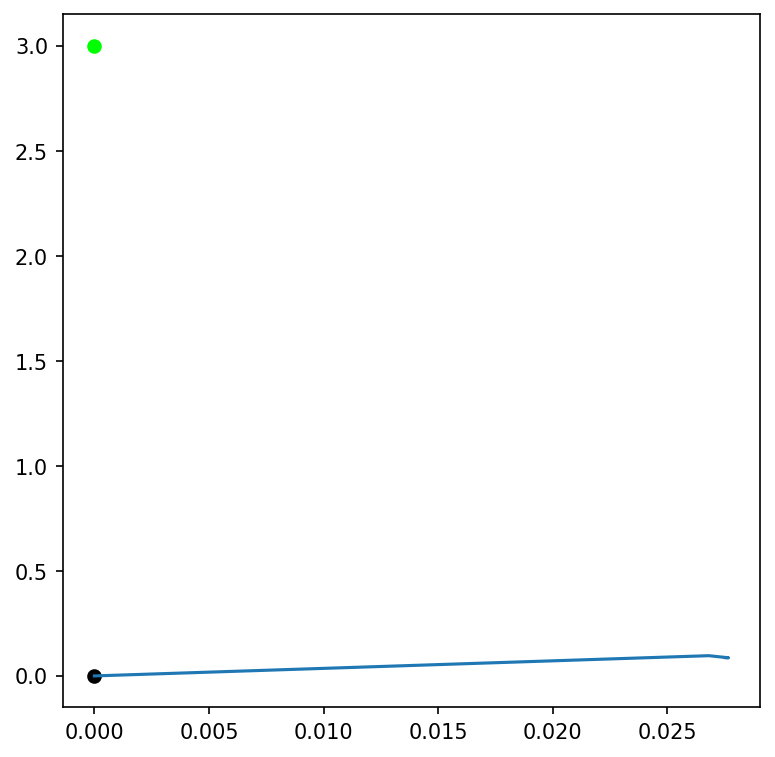

In [ ]:
plot_navigation(position_sequence, graph_test_navigation.feeder_position, 1000)